In [113]:
import sys

sys.path.append('../')

In [114]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from config.regressors import NNRegressor

In [115]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        # Encoder: [3 → 64 → 32 → 16 → latent_dim]
        self.encoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, 4),
            nn.SELU(),
            nn.Linear(4, latent_dim)  # No activation
        )
        
        # Decoder: [latent_dim → 16 → 32 → 64 → 3]
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 4),
            nn.SELU(),
            nn.Linear(4, 8),
            nn.SELU(),
            nn.Linear(8, 16),
            nn.SELU(),
            nn.Linear(16, 3)  # No activation
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # LeCun normal initialization for SELU
                nn.init.normal_(m.weight, 0, std=1. / np.sqrt(m.in_features))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [116]:
def trainer(bone, latent_dim):
    # ----------------------------
    # 1. Configuration
    # ----------------------------
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Hyperparameters
    batch_size     = 4096
    learning_rate  = 1e-3
    weight_decay   = 1e-4
    max_epochs     = 100
    patience       = 20
    num_workers    = 4  # >0 for parallel loading

    # ----------------------------
    # 2. Prepare Data (CPU‑only)
    # ----------------------------
    # Assume Y is your NumPy array of shape [N, 3*B]
    PATH = f'/Users/marco/PROJECTS/data/'
    Y = np.load(PATH + 'Y_all.npy')
    Y_bone = Y[:, bone*3:(bone+1)*3]

    Yb_cpu   = torch.as_tensor(Y_bone, dtype=torch.float32)  # stays on CPU

    dataset      = TensorDataset(Yb_cpu, Yb_cpu)
    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        persistent_workers=True
    )
    val_loader   = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        persistent_workers=True
    )

    # instantiate with your chosen latent dimension
    model = AutoEncoder(latent_dim).to(device)

    # ----------------------------
    # 4. Loss & Optimizer
    # ----------------------------
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    # ----------------------------
    # 5. Training Loop w/ Early Stopping
    # ----------------------------
    best_val_loss     = float('inf')
    epochs_no_improve = 0

    for epoch in range(1, max_epochs+1):
        # —— Training —— 
        model.train()
        running_loss = 0.0

        for xb_cpu, yb_cpu in train_loader:
            # move batch to MPS (or CUDA) on-the-fly
            xb = xb_cpu.to(device, non_blocking=True)
            yb = yb_cpu.to(device, non_blocking=True)

            optimizer.zero_grad()
            preds = model(xb)              
            loss  = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # —— Validation ——
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for xb_cpu, yb_cpu in val_loader:
                xb = xb_cpu.to(device, non_blocking=True)
                yb = yb_cpu.to(device, non_blocking=True)
                running_val += criterion(model(xb), yb).item()
        avg_val_loss = running_val / len(val_loader)

        print(f"Epoch {epoch:02d}: Train MSE = {avg_train_loss:.6f} | Val MSE = {avg_val_loss:.6f}")

        # —— Early Stopping ——
        if avg_val_loss < best_val_loss:
            best_val_loss     = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), f"best_models/best_model_bone{bone}.pth")
            print("  → New best model saved")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break

In [117]:
latent_dims = {
    0: 1,
    1: 1,
    2: 1,
    3: 1,
    4: 2,
    5: 1,
    6: 1,
    7: 2,
    8: 1,
    9: 1,
    10: 2,
    11: 1,
    12: 1,
    13: 1,
    14: 2,
    15: 1,
    16: 1,
}

### Test

In [118]:
from config.transformers import TimeDomainTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

baseline_kr = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KernelRidge(
            alpha = 0.01,
            gamma = 0.01,
            kernel='laplacian'))
    ]
)

baseline_knn = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor(
            n_neighbors = 5))
    ]
)

baseline_rf = Pipeline(
    [
        ('feature_extraction', TimeDomainTransformer(sigma_mpr=0.3)),
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(
            n_estimators = 50,
            max_depth = 10))
    ]
)

In [119]:
import numpy as np

PATH = f'/Users/marco/PROJECTS/data/'
# PATH = r'C:\Users\gianm\Documents\Uni\Big Data\F422\project\data\\'

DATASET = 'guided'
X_freemoves = np.load(PATH + f'{DATASET}/{DATASET}_dataset_X.npy')         # shape (5, 8, 230000)
Y_freemoves = np.load(PATH + f'{DATASET}/{DATASET}_dataset_Y.npy')         # shape (5, 51, 230000)

In [120]:
Y_freemoves_enc = []

for bone in range(17):
    latent_dim = latent_dims[bone]
    model = AutoEncoder(latent_dim=latent_dim).to('mps')
    model.load_state_dict(torch.load(f'best_models/best_model_bone{bone}.pth'))

    to_encode = Y_freemoves[:, 3*bone:3*(bone+1)]
    to_encode = to_encode.transpose(0,2,1).reshape(-1, 3)
    to_encode_tensor = torch.tensor(
        to_encode,
        dtype=torch.float,
        device='mps')
    encoded_tensor = model.encoder(to_encode_tensor)
    Y_freemoves_enc.append(encoded_tensor\
        .cpu().detach().numpy()\
        .reshape(5, 230000, latent_dim)\
        .transpose(0,2,1))

Y_freemoves_enc = np.hstack(Y_freemoves_enc)

In [121]:
from config.transformers import TimeWindowTransformer, LabelWindowExtractor

# define parameters
size = 500
step = 250

# initialize transformers
tw_transformer = TimeWindowTransformer(size=size, step=step)
label_extractor = LabelWindowExtractor(size=size, step=step)

# apply transformations
X_freemoves_windows = tw_transformer.transform(X_freemoves)           # shape: (5, n_windows, 8, 500)
Y_freemoves_labels = label_extractor.transform(Y_freemoves)
Y_freemoves_enc_labels = label_extractor.transform(Y_freemoves_enc)

In [122]:
from config.validation import cross_validate_pipeline, RMSE, NMSE

X_folds = np.vstack(X_freemoves_windows[:4])
X_test = X_freemoves_windows[4]

Y_folds = np.vstack(Y_freemoves_labels[:4])
Y_test = Y_freemoves_labels[4]

Y_enc_folds = np.vstack(Y_freemoves_enc_labels[:4])
Y_enc_test = Y_freemoves_enc_labels[4]

In [123]:
pipeline = baseline_knn

In [124]:
pipeline.fit(X_folds, Y_folds)
Y_pred = pipeline.predict(X_test)

In [125]:
RMSE(Y_pred, Y_test)

np.float64(4.589927200536382)

In [126]:
pipeline.fit(X_folds, Y_enc_folds)

Y_enc_pred = pipeline.predict(X_test)

In [127]:
current = 0
Y_dec_pred = []
for bone in range(17):
    latent_dim = latent_dims[bone]
    model = AutoEncoder(latent_dim=latent_dim).to('mps')

    model.load_state_dict(torch.load(f'best_models/best_model_bone{bone}.pth'))

    to_decode = Y_enc_pred[:, current:current + latent_dim]
    current += latent_dim

    bone_data_tensor = torch.tensor(to_decode, dtype=torch.float, device='mps')
    bone_data_tensor_dec = model.decoder(bone_data_tensor)
    Y_dec_pred.append(bone_data_tensor_dec.cpu().detach().numpy())

Y_dec_pred = np.hstack(Y_dec_pred)

In [128]:
RMSE(Y_dec_pred, Y_test)

np.float64(4.540428741006081)

In [129]:
Y_ensemble = (Y_dec_pred + Y_pred)/2

In [130]:
RMSE(Y_ensemble, Y_test)

np.float64(4.563006935335711)

In [131]:
from config.utils import scatter_3d_points

<Axes3D: xlabel='Roll', ylabel='Yaw', zlabel='Pitch'>

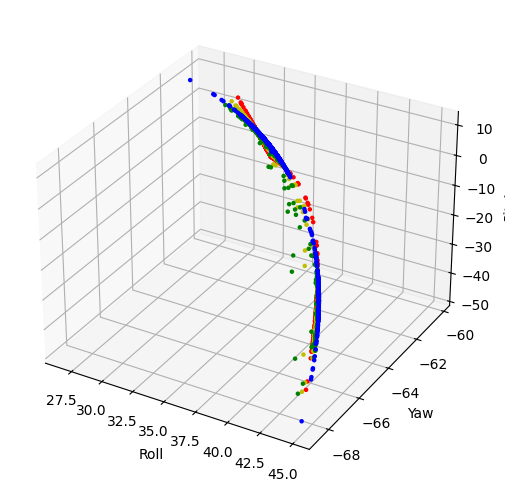

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline

bone = 0

ax = scatter_3d_points(Y_test[:, 3*bone:3*(bone+1)])
scatter_3d_points(Y_dec_pred[:, 3*bone:3*(bone+1)], ax=ax, color='r')
scatter_3d_points(Y_pred[:, 3*bone:3*(bone+1)], ax=ax, color='g')
scatter_3d_points(Y_ensemble[:, 3*bone:3*(bone+1)], ax=ax, color='y')